# Geological models with `curlew`

This tutorial covers the basic aspects of geological modelling, building simple synthetic models with various structures, and sampling them. With `curlew.fields.analytical`, one can generate a huge variety of synthetic examples, as is demonstrated in this notebook.

In [3]:
# Import the necessary libraries
import curlew
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Plotting params (For an even prettier look!)
# N.B. You can skip this cell completely if you don't want to 
# customize the plotting style

from matplotlib import colors
import matplotlib as mpl
import matplotlib.font_manager as font_manager

font_dirs = ['../Utils/',]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs[0], fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Plotting params
# RCParams
import matplotlib as mpl
mpl.rcParams["text.usetex"] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["mathtext.default"] = "it"
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['font.size'] = 18
plt.rcParams["axes.formatter.limits"] = [-2, 2]

# Curlew colormap
import matplotlib.colors as mcolors

# Define the colors extracted manually from the provided logo image
colors = [
    "#A6340B",  # rich red (not darkest)
    "#E35B0E",  # vibrant orange-red
    "#F39C12",  # medium orange
    "#F0C419",  # bright orange-yellow
    "#FAE8B6",  # soft pale orange (close to white but not pure white)
    "#8CD9E0",  # light cyan blue
    "#31B4C2",  # medium cyan-blue
    "#1B768F",  # medium blue 
    "#054862",  # deeper blue (not darkest)
]

# Create a discrete colormap using these colors
curlew_cmap = mcolors.ListedColormap(colors)

# Random seed
import random
random.seed(42)

## The basic building block: Analytical Implicit Fields

Implicit representations of the subsurface require implicit analytical functions i.e. functions with a pre-defined analytical expression, that can be evaluated everwhere within the domain of interest. We have incorporated various analytical expressions within `curlew.fields.analytical` that allow for generation of complex geometries. Let us build a simple 2D analytical implicit geological model!

In [ ]:
# Let us generate a simple sinusoidal folded model.
import curlew.geometry as cgeom

# Define the grid
dims = (2000,1000)  # dimensions of our 2D section
# Initialise a grid object
grid_obj = cgeom.grid(
    dims=dims, # Dimensions
    step=(5,5), # Grid spacing
    origin=(dims[0]/2, dims[1]/2) # Origin
)
# Extract the grid coordinates
xy = grid_obj.coords()

In [ ]:
# Next we import the building blocks of the model defined within curlew.geology,
# and the analytical sinusoidal field (ASF) from curlew.fields.analytical
from curlew.geology import strati
from curlew.fields.analytical import ASF

# Define a field
s0 = strati(
    's0', # Name
    C=ASF('f0', input_dim=2, scale=20)
)

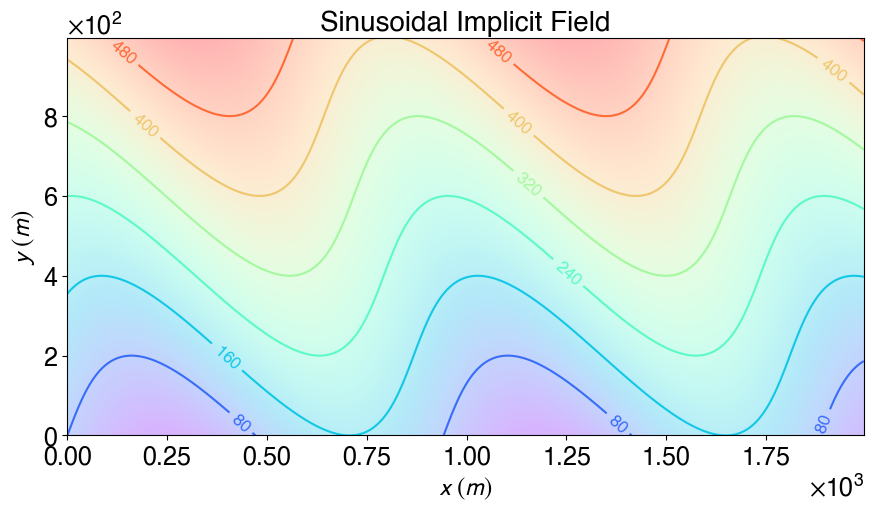

In [21]:
# Evaluate the field on the grid coordinates!
s = s0.predict(xy)

# Plot to show the field
from curlew.visualise import plot2D

fig, ax = plt.subplots(1, 1, figsize=(10, 5), layout="compressed")
plot2D(s[:, 0], grid_obj, ax=ax)
ax.set_title("Sinusoidal Implicit Field")
ax.set_xlabel(r"$x\ (m)$")
ax.set_ylabel(r"$y\ (m)$")
plt.show()

## Bravo!

You have made your first analytical implicit field. While this might be good for a simple folded basement, we would like to have some more complexity within our fields. Let us introduce an unconformity into the mix!

In [22]:
# Let us import the analytic curved field (ACF)
from curlew.fields.analytical import ACF

# Define an unconformity
s1 = strati(
    's1',
    C=ACF('f1', input_dim=2, gradient=[0.1, 0.9], origin=(1000, 500), curve=(-0.00002,0)), # THe curved field
    base=0 # Base level of the unconformity
)

# To combine multiple fields together, we use the curlew.geology.model.GeoModel class
from curlew.geology.model import GeoModel

# Define a geological model with the two stratigraphic units
# The order of the events is oldest to youngest within the list.
# Hence the folded basement comes first, followed by the unconformity
M = GeoModel([s0, s1])

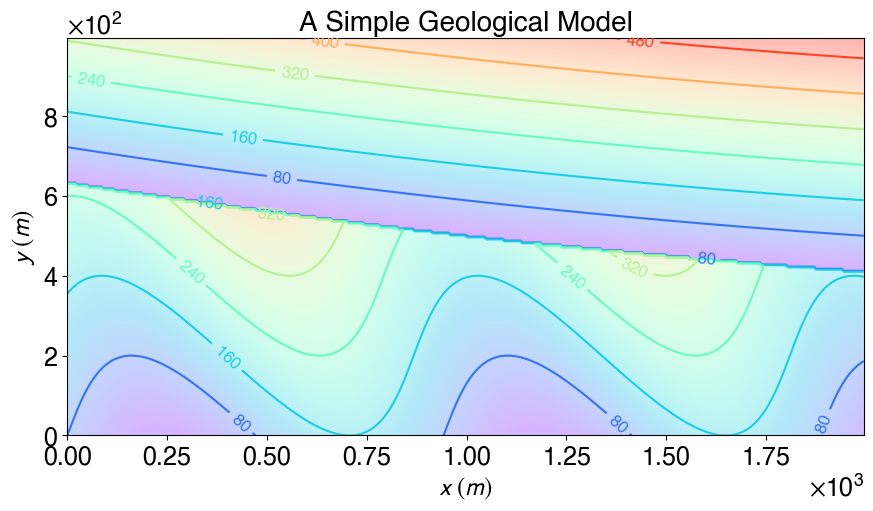

In [23]:
# Evaluate the GeoModel on the grid coordinates!
s = M.predict(xy)

fig, ax = plt.subplots(1, 1, figsize=(10, 5), layout="compressed")
plot2D(s[:, 0], grid_obj, ax=ax)
ax.set_title("A Simple Geological Model")
ax.set_xlabel(r"$x\ (m)$")
ax.set_ylabel(r"$y\ (m)$")
plt.show()

In [6]:
from curlew.data import linear, folds

dims = (2000,1000)  # dimensions of our 2D section
xy, s0 = folds( dims ) # generate a folded basement field (sampled at xy, and with values s0)
xy, s1 = linear( dims, gradient=[0.1,0.9], offset=[0,-150], curve=(-0.00005,0) ) # generate a tilted unconformity field (sampled at xy, and with values s0)

ImportError: cannot import name 'linear' from 'curlew.data' (/Users/kamath92/Documents/Work/2025/CURLEW/Final Repository/curlew/curlew/data.py)

Then we combine these two scalar fields, such that `s1` overprints (replaces) `s0` where `s1 > 1`. We also generate some colours here to visualise these scalar fields as though they were geological units.

Lastly, to complete our synthetic dataset, we sample unit (value) and bedding orientation (gradient) constraints from this scalar field (which we'll then use to build a GeoModel).

/var/folders/pk/f4t2c6dx7r1_3km_vttz8t480000gr/T/ipykernel_48020/86734355.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


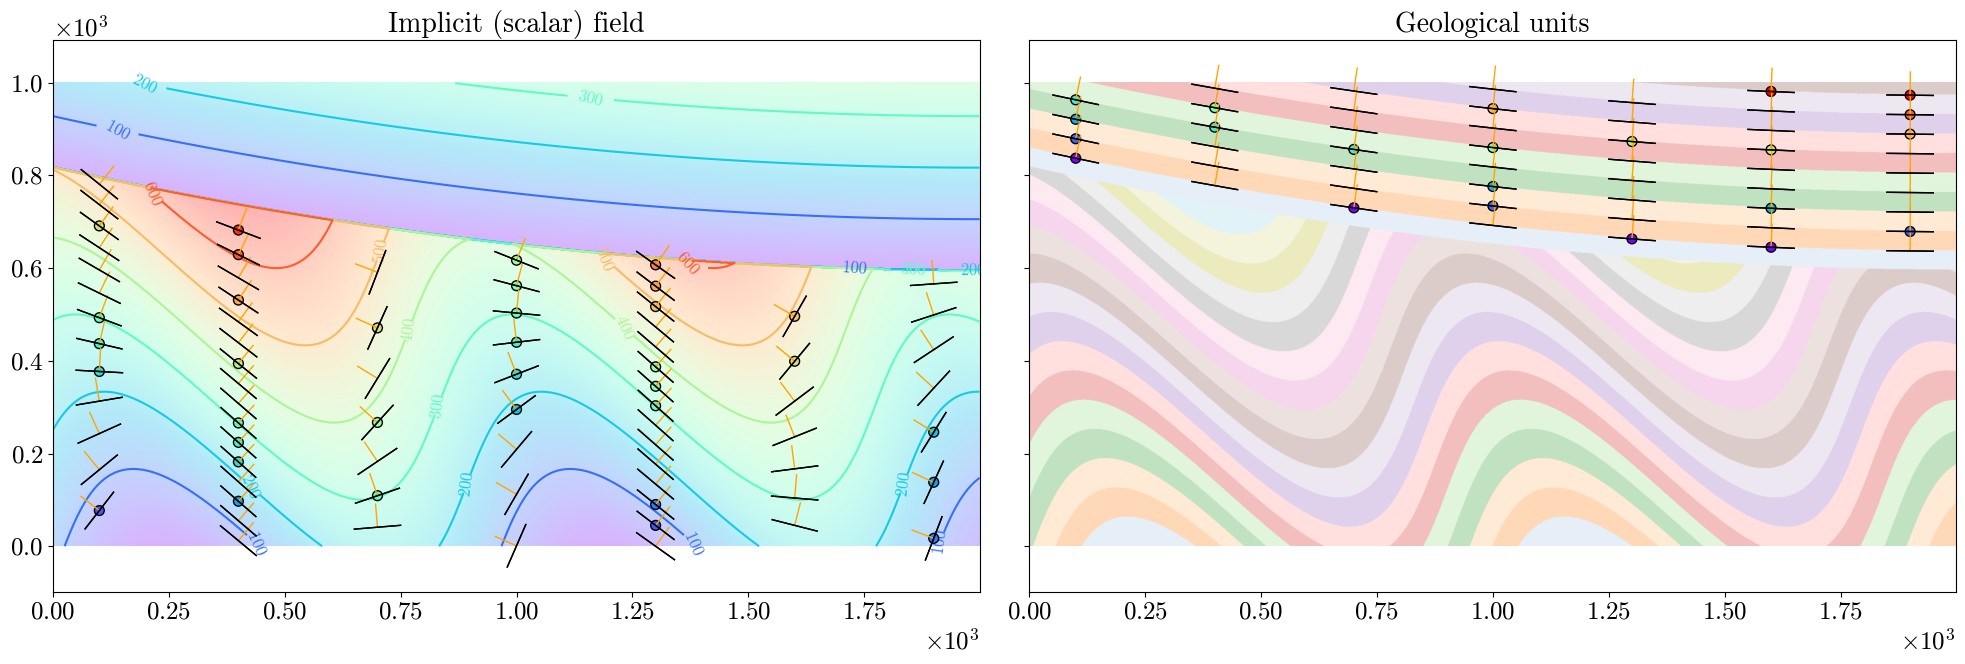

In [4]:
from curlew.geology.interactions import overprint
from curlew.data import colour, sample

s = overprint( s0, s1, thresh=1 ) # overprint s0 with s1 where s1 > 1
c = colour(s[:,0]) # discretise resulting scalar field into colours for visualisation
C0, C1 = sample( xy, s, dims, xstep=300, pval=0.4 ) # sample unit and bedding constraints

# plot our resulting synthetic model
from curlew.visualise import plot2D
fig,ax = plt.subplots(1,2,figsize=(20,12), sharex=True, sharey=True)
plot2D( xy, s[:,0], dims, C=C0, ax=ax[0] ) # plot scalar field
plot2D( xy, c, dims, C=C1, ax=ax[1] ) # plot RGB field
ax[0].set_title("Implicit (scalar) field")
ax[1].set_title("Geological units")
fig.tight_layout()
fig.show()

#### Neural fields

Now that we have some data (and a ground truth!) we can construct some neural field models. 

First, we'll interpolate our two stratigraphic series seperately, and explore some of the different hyperparameters that influence the results.

The most important of these are: 

1. `length_scales`, which determines the frequencies used to encode our positions before interpolation. This strongly influences the smoothness of the interpolation.

2. `mono_loss`, which encourages the interpolated field to be divergence free (i.e. penalise the local maxima that lead to geologically impossible "bubbles").

3. `thick_loss`, which encourages the interpolated field to have a constant gradient magnitude everywhere (i.e. penalise large changes in thickness).

Tuning these last two parameters can be very important -- especially as they are often in direct conflict, because the only divergence free scalar field with a constant gradient magnitude is a... layer cake stratigraphy!

Lets explore each of these individually.

***Scale***

Plot three interpolations of our two scalar fields using different scales.


In [5]:
from curlew import NF, HSet
nepochs = 200 # how long to train our neural fields

# create a grid to evaluate outputs one
from curlew.geometry import grid
gdims, gxy = grid( dims, step=(5,5), origin=(0,0) )

Fitting Folded Basement Field


Training: 200/200|, value_loss=8.56e-6, grad_loss=8.5e-7  
Training: 200/200|, value_loss=0.000408, grad_loss=0.00307
Training: 200/200|, value_loss=0.0543, grad_loss=0.16 


Fitting Unconformity Field


Training: 200/200|, value_loss=1.2e-5, grad_loss=1.43e-6  
Training: 200/200|, value_loss=0.000207, grad_loss=0.000191
Training: 200/200|, value_loss=0.00454, grad_loss=0.000221 
/var/folders/pk/f4t2c6dx7r1_3km_vttz8t480000gr/T/ipykernel_48020/2888269808.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


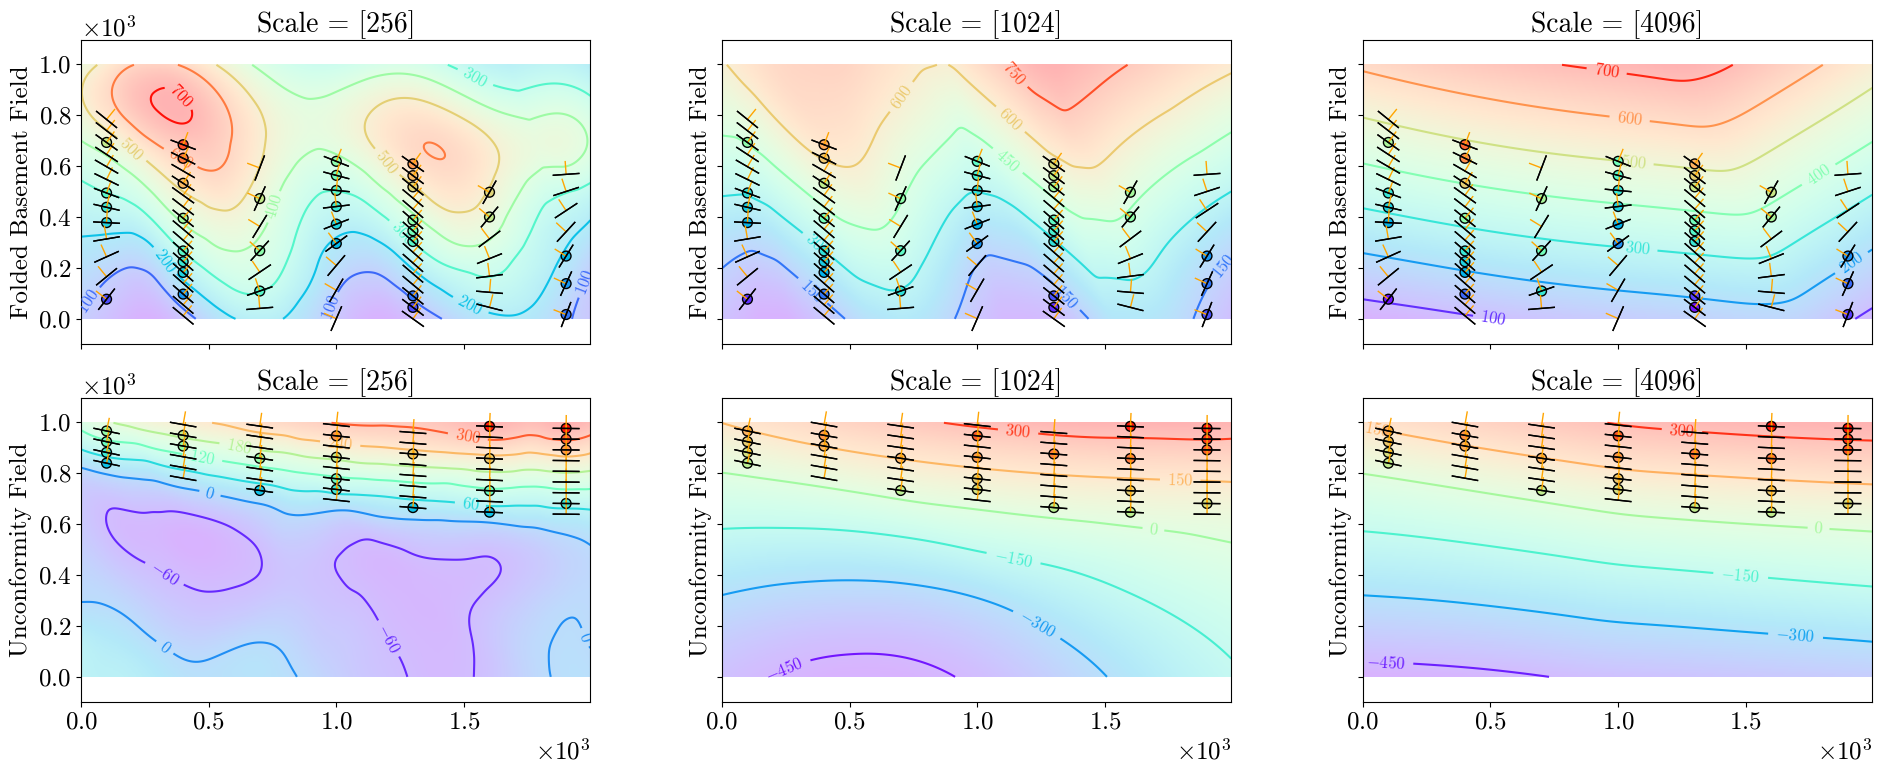

In [6]:
H = HSet( value_loss="1", # strength of penalty for mismatch between value constraints and field outputs
          grad_loss=1,  # strength of penalty for mismatch between gradient constraints and field gradients
          mono_loss=0, thick_loss=0) # disable these for now

# try some different scales
scales = [ [256], [1024], [4096] ] # play with these. Note also that a field can have multiple scales!
fig,ax = plt.subplots(2,len(scales), figsize=(20,8), sharex=True, sharey=True)
names = ['Folded Basement Field','Unconformity Field']
for j, C in enumerate( [C0, C1] ):
        print("Fitting %s"%names[j])
        for i, scale in enumerate( scales ):
                # create a neural field
                s0 = NF( H, # hyperparameters
                        name='f0', # name (just for convenience)
                        input_dim=2, # field input coordinate dimensions (2D in our case)
                        hidden_layers=[128,], # hidden layers in the multi-layer perceptron that parameterises our field
                        rff_features=64, # number of random sin and cos features to create for each scale 
                        length_scales=scale) # the length scales in our model

                # fit it
                _, loss = s0.fit( nepochs, C )

                # predict on our grid and plot the results
                pred = s0.predict(gxy)
                plot2D( gxy, pred[:,0], gdims[:-1], C=C, ax=ax[j,i]) # plot predicted field
                ax[j,i].set_title("Scale = %s"%scale)
                ax[j,i].set_ylabel(names[j])

fig.tight_layout()
fig.show()

As clearly shown above, the `length_scales` parameter used by our neural field has a big influence on the result! This means it needs to be carefully selected, but also can be used as a powerful constraint for geological units in which the typical scale of periodicity (e.g., folded units) is known.

Unsurprisingly, our folded unit performed best with shorter wavelength fourier encoding, while the flat stratigraphy requires longer wavelengths.

While these examples work relatively well with a single scale, most real geometries will require several carefully selected scales for best results.

***Monotonicity***

The results above also show that simply fitting gradient and value constraints is insufficient for geological modelling, as often the best-fit scalar field contains local maxima or minima that violate (for sedimentary units) the principle of superposition and cause geologically impossible "closed" bedding surfaces, commonly called "bubbles". 

The flexibility of the Neural Field approach allows us to include this in the loss function, by evaluating the divergence of the scalar field and penalising non-zero values (maxima and minima result in large divergence values). This encourages the Neural Field to find a solution that is approximately harmonic. 

Unlike the previous constraints, which are applied at a specific (x,y) location, we want the entire field (within our model domain) to be monotonous. Hence, we now need to define a control grid at which this constraint (and other "global" properties) can be enforced. This can be relatively sparse, but should cover the whole model domain.

In [7]:
# define a random grid of control points to evaluate these "global" losses
# (this random grid will be sampled during each epoch!)
for C in [C0,C1]:
    C.grid = (1024,[(-100,dims[0]+100),(-100,dims[1]+100)]) # specify (NGridPoints, [(xmn,xmx), (ymn,ymx)])
    C.delta = 50 # numerical differentiation step used (in each axis)

# N.B. uncomment the following code if you want to use a regular grid
# define a grid of control points to evaluate our "global" losses
#_, cxy = grid( [d+100 for d in dims], step=(100,100), origin=(0,0) ) 


The following code tries a few values of monotonicity loss, as it's necessary to balance the strength of this global constraint against the need to still fit our actual data. The string notation (e.g., `"0.01"`) when defining the weighting specifies that this will be scaled by the initial loss magnitude (i.e. the inital average divergence of the scalar field). We could also set this explicitely by passing a `float`, but often it is only the relative loss contributions that we care about.

Fitting Folded Basement Field


Training: 0/200|, value_loss=1, grad_loss=0.845

Training: 200/200|, value_loss=0.0962, grad_loss=0.0188
Training: 200/200|, value_loss=0.109, grad_loss=0.0156, mono_loss=0.0189
Training: 200/200|, value_loss=0.125, grad_loss=0.0193, mono_loss=0.0254


Fitting Unconformity Field


Training: 200/200|, value_loss=0.00357, grad_loss=0.00162
Training: 200/200|, value_loss=0.00716, grad_loss=0.00205, mono_loss=0.000449
Training: 200/200|, value_loss=0.0112, grad_loss=0.00242, mono_loss=0.000566
/var/folders/pk/f4t2c6dx7r1_3km_vttz8t480000gr/T/ipykernel_48020/1837693720.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


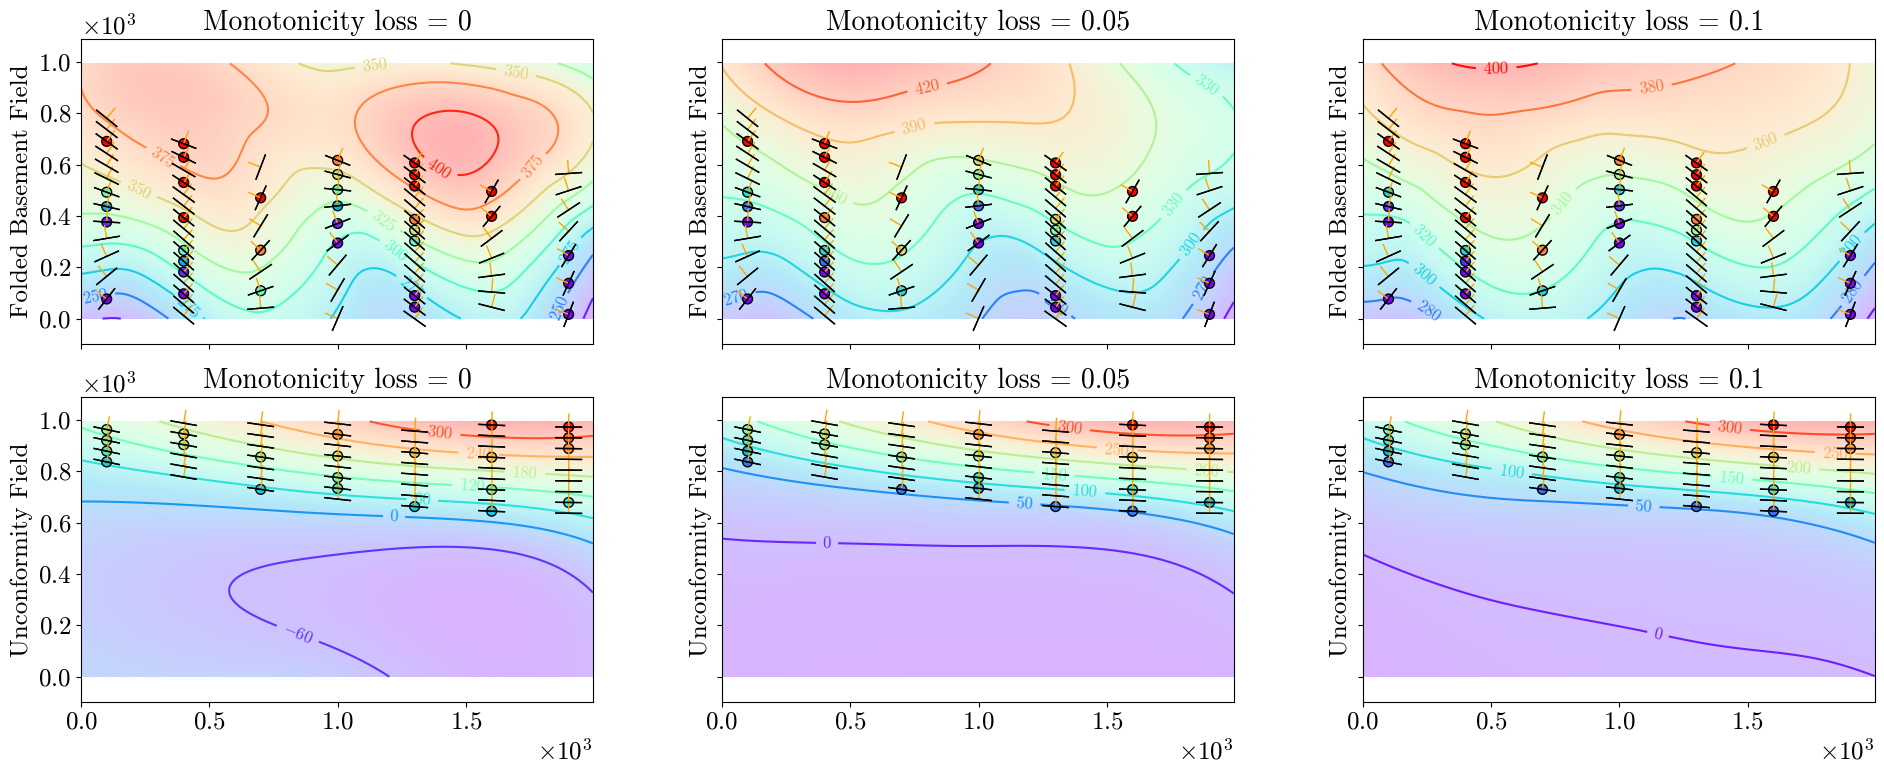

In [8]:
# try some different mono losses
mono_loss = [ 0, "0.05", "0.1" ] # play with these.
fig,ax = plt.subplots(2,len(mono_loss), figsize=(20,8), sharex=True, sharey=True)
names = ['Folded Basement Field','Unconformity Field']

scales = [[500], [500]] # use small scales here to show the effect better
for j, C in enumerate( [C0, C1] ):
        print("Fitting %s"%names[j])
        for i, mono in enumerate( mono_loss ):

                H = HSet( value_loss="1",  # disable value constraints to emphasise differences
                          grad_loss=1,  
                          mono_loss=mono, # set monotonicity loss. 
                          thick_loss=0, flat_loss=0) # lets disable this for now
                
                # create a neural field
                s0 = NF( H, # hyperparameters
                        name='f0',
                        input_dim=2, 
                        hidden_layers=[128],
                        rff_features=32,  
                        length_scales=scales[j],
                        learning_rate=0.01,
                        seed=42) # change this to get different realisations!

                # fit it
                _, loss = s0.fit( nepochs, C )

                # predict on our grid and plot the results
                pred = s0.predict(gxy)
                plot2D( gxy, pred, gdims[:-1], C=C, ax=ax[j,i] ) # plot predicted field
                ax[j,i].set_title("Monotonicity loss = %s"%mono)
                ax[j,i].set_ylabel(names[j])
        
fig.tight_layout()
fig.show()

As shown above, `mono_loss` tends to push maxima and minima towards the edge of our domain (at least, the domain covered by our control grid), such that they're no longer local maxima. 

While the scale used for these models is too small (resulting in ugly bumpy isosurface), it is clear that the `mono_loss` encourages more geologically reasonable results, for stratigraphic series. If we were modelling e.g., an intrusion or a batholith, then we would want closed isosurfaces and so disable monotonicity loss (`mono_loss=0`).

***Thickness loss***
Last but not least in our exploration of some of the key hyperparameters of our neural field model, we will explore different values of `thick_loss`. 

All of the above interpolation examples have areas where the magnitude of the gradient of our scalar field changes significantly (causing the isosurfaces of the field to get closer together or further apart, changing the "thickness" of the stratigraphic units they bound). In some cases we want our interpolated scalar field to approximate a true distance field (i.e. have a constant gradient magnitude). This can be encouraged using `thick_loss`.

Fitting Folded Basement Field


Training: 200/200|, value_loss=0.00634, grad_loss=0.0105
Training: 200/200|, value_loss=0.0148, grad_loss=0.0183, thick_loss=0.0118
Training: 200/200|, value_loss=0.104, grad_loss=0.0327, thick_loss=0.0163


Fitting Unconformity Field


Training: 200/200|, value_loss=0.00223, grad_loss=0.00112
Training: 200/200|, value_loss=0.00343, grad_loss=0.00101, thick_loss=0.00773
Training: 200/200|, value_loss=0.0683, grad_loss=0.00301, thick_loss=0.0131
/var/folders/pk/f4t2c6dx7r1_3km_vttz8t480000gr/T/ipykernel_48020/40709135.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


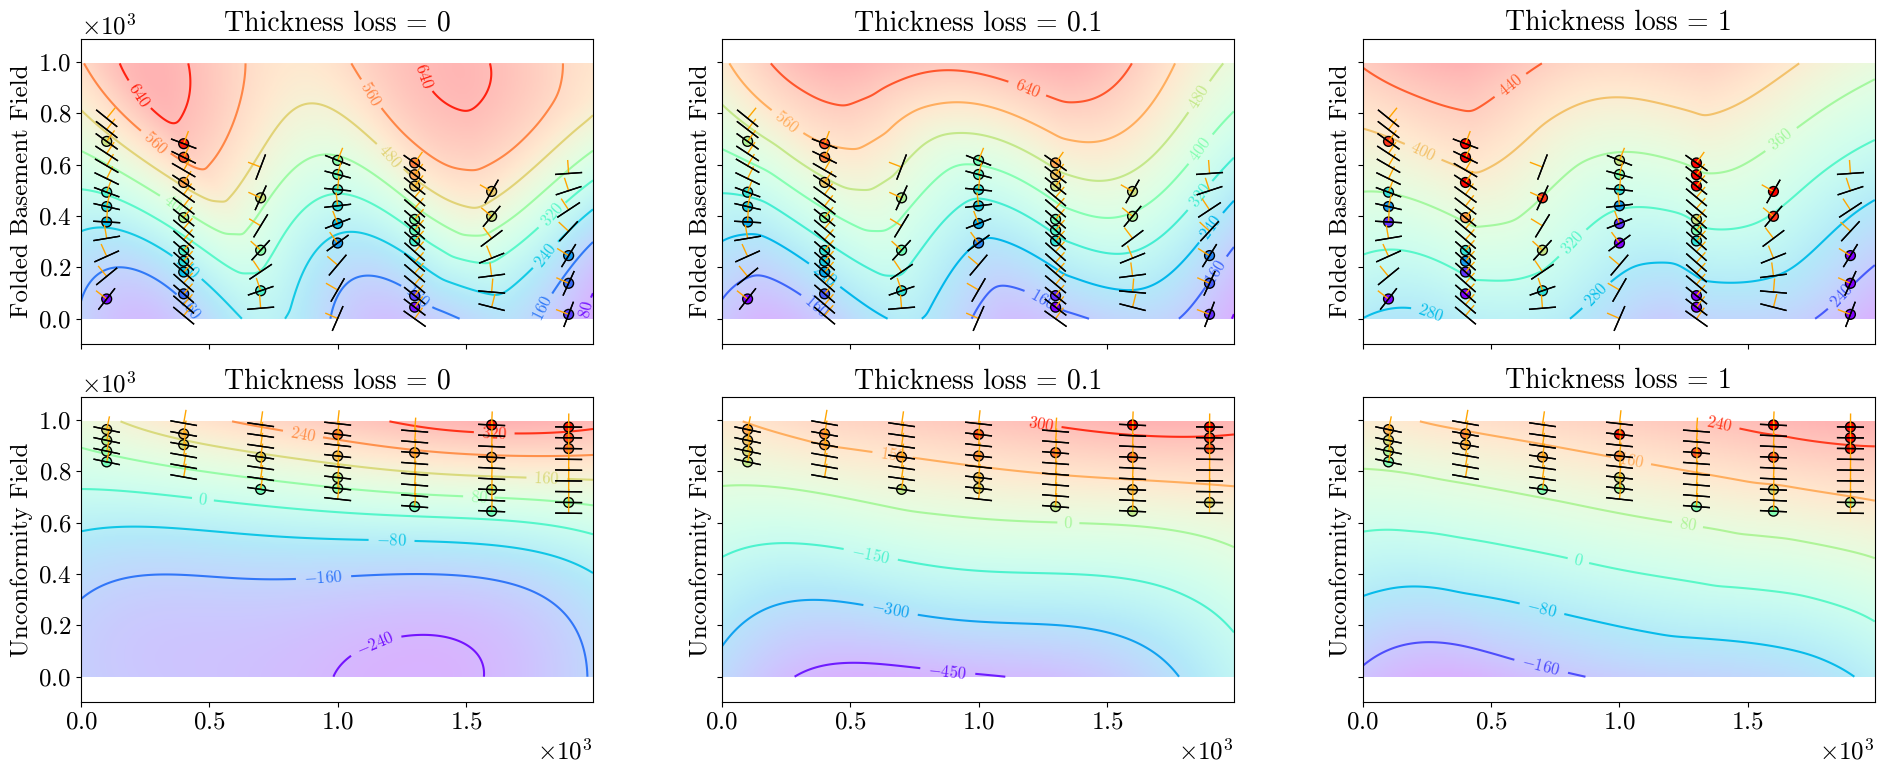

In [9]:
# try some different thickness losses
thick_loss = [ 0, "0.1", "1"] # play with these.
fig,ax = plt.subplots(2,len(thick_loss), figsize=(20,8), sharex=True, sharey=True)
names = ['Folded Basement Field','Unconformity Field']

scales = [[500, 2000], [500, 2000]] # use small scales here to show the effect better
for j, C in enumerate( [C0, C1] ):
        print("Fitting %s"%names[j])
        for i, thick in enumerate( thick_loss ):

                H = HSet( value_loss="1.0", grad_loss=1,  # strength of penalty for mismatch between gradient constraints and field gradients
                mono_loss=0, # disable mono loss
                thick_loss=thick) # vary thickness loss
                
                # create a neural field
                s0 = NF( H, # hyperparameters
                        name='f0',
                        input_dim=2, 
                        hidden_layers=[256,],
                        rff_features=64, 
                        length_scales=scales[j],
                        learning_rate=0.01)

                # fit it
                _, loss = s0.fit( nepochs, C )

                # predict on our grid and plot the results
                pred = s0.predict(gxy)
                plot2D( gxy, pred, gdims[:-1], C=C, ax=ax[j,i] ) # plot predicted field
                ax[j,i].set_title("Thickness loss = %s"%thick)
                ax[j,i].set_ylabel(names[j])

fig.tight_layout()
fig.show()

The isosurfaces in the final model (`thick_loss = 1.0`) are nearly equidistant, showing how the loss encourages smoothly varying fields. 

However, strong thickness losses must be used with care, as often they directly conflict with monotonicity loss (as the only monotonic (divergence free) scalar field with a constant gradient magnitude is... a layercake stratigraphy. All deviations from this require either some change in gradient magnitude or some divergence). 

#### Conclusions

To conclude, the above exercises have shown how neural fields (and the fixed-wavelength fourier-feature encoding we use to encode position) can smoothly interpolate geological implicit (scalar) fields. Local constraints can be applied to fit this field to value (stratigraphic position) and gradient (bedding or structure orientation), while global constraints can be imposed on a grid to encourage bubble-free (harmonic) scalar fields or enforce constant gradient (thickness) such that the field represents some curvi-linear distance.

The next notebook will put these concepts together to construct a geological model, in which the outputs of each field are combined to create a temporally aware structural geologial model.